In [9]:
# Import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_csv("../data/processed/all_shots_only_selected_features.csv", index_col=0)
df.drop(['PLAYER1_NAME'], axis=1, inplace=True)
df.columns

Index(['Shot Distance', 'X Location', 'Y Location', 'Season Type',
       'Shot Zone Basic_Backcourt', 'Shot Zone Basic_In The Paint (Non-RA)',
       'Shot Zone Basic_Left Corner 3', 'Shot Zone Basic_Mid-Range',
       'Shot Zone Basic_Restricted Area', 'Shot Zone Basic_Right Corner 3',
       'Shot Zone Area_Back Court(BC)', 'Shot Zone Area_Left Side(L)',
       'Shot Zone Area_Right Side Center(RC)', 'Shot Zone Area_Right Side(R)',
       'Shot Zone Range_8-16 ft.', 'Shot Zone Range_Back Court Shot',
       'Shot Zone Range_Less Than 8 ft.', 'at_home', 'PREVIOUS_OFF_REBOUND',
       'PREVIOUS_DEF_REBOUND', 'dunk_shot', 'PREVIOUS_OFF_MISSED', 'Age',
       'TS%', 'PTM', 'ASTM', 'ORBM', 'STLM', 'BLKM', 'USG%', 'FG%', '2P%',
       'FT%', 'PTS', 'height', 'weight', 'C', 'PG', 'PG-SG', 'SF', 'SF-SG',
       'SG', 'SG-PG', 'E_DEF_RATING', 'E_OFF_RATING', 'PCT_PREV_ACTION',
       'PCT_AREA', 'YEARS_EXP', 'DETAILLED_SHOT_TYPE_FREE THROW',
       'DETAILLED_SHOT_TYPE_OTHER', 'target'],
   

In [4]:
df.corr()['target'].abs().sort_values(ascending=False)[:15]

target                                   1.000000
DETAILLED_SHOT_TYPE_FREE THROW           0.268635
Shot Zone Range_8-16 ft.                 0.167854
dunk_shot                                0.158957
PCT_PREV_ACTION                          0.156375
PREVIOUS_OFF_MISSED                      0.132595
PCT_AREA                                 0.132379
Shot Distance                            0.132153
Shot Zone Basic_Mid-Range                0.106453
Shot Zone Area_Right Side Center(RC)     0.106183
Shot Zone Basic_In The Paint (Non-RA)    0.104620
Shot Zone Basic_Restricted Area          0.096861
Shot Zone Area_Left Side(L)              0.095131
Shot Zone Area_Right Side(R)             0.087952
PREVIOUS_DEF_REBOUND                     0.076431
Name: target, dtype: float64

## Séparation des données

In [5]:
# prepare data for modeling   
X = df.drop('target', axis = 1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)

## Standardisation et réduction de dimension

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_scaled['target'] = y_train

# réduction de dimensions
sel_var = VarianceThreshold(0.001)
X_train_scaled = sel_var.fit_transform(X_train_scaled, y_train)
X_test_scaled = sel_var.transform(X_test_scaled)

# réduction de dimensions
sel_k_best = SelectKBest(f_classif, k = 20)
sel_k_best.fit(X_train, y_train)
X_train_kbst = sel_k_best.transform(X_train)
X_test_kbst = sel_k_best.transform(X_test)

# Affichage des variables sélectionnées
# kbst = pd.DataFrame(sel_k_best.get_support(), index=X_train.columns)
# kbst["score"]=sel_k_best.scores_
# kbst.sort_values("score", ascending=False)

Composantes Principales retenues :  29


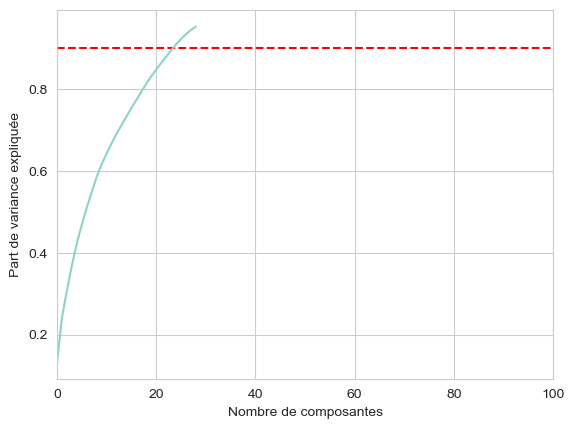

In [10]:
pca = PCA()
pca.fit(X_train_scaled)

pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Composantes Principales retenues : ", pca.n_components_)

plt.figure()
plt.xlim(0,100)
plt.xlabel('Nombre de composantes')
plt.ylabel('Part de variance expliquée')
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

## Arbre de décision

In [7]:
dt_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=7, min_samples_split=5)

dt_clf.fit(X_train_kbst, y_train)
y_pred = dt_clf.predict(X_test_kbst)
print('Train accuracy with DT:', dt_clf.score(X_train_kbst, y_train))
print('Test accuracy with DT:', dt_clf.score(X_test_kbst, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy with DT: 0.6799778131755604
Test accuracy with DT: 0.6804187051996814


Classes prédites,0,1
Classes réelles,,
0,23621,14714
1,13374,36181


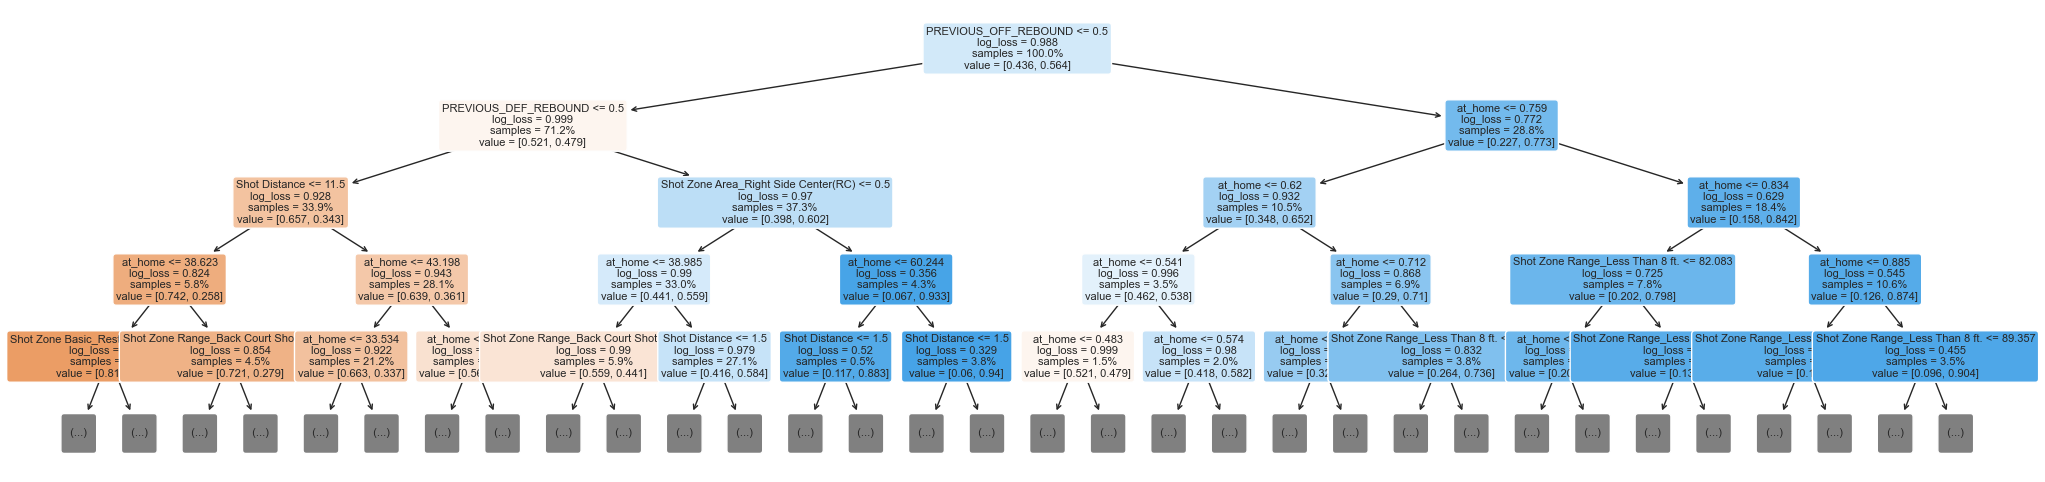

In [11]:
plt.figure(figsize=(25,6))
plot_tree(dt_clf,feature_names=X_train.columns, filled=True, proportion=True, rounded=True, fontsize=8, max_depth=4)
plt.show()

In [ ]:
import optuna

def dtree_objective(trial):
    
    md = trial.suggest_int('max_depth', 2, 64)
    mi = trial.suggest_int('min_samples_split', 2, 32)
    cr = trial.suggest_categorical("criterion", ["entropy", "gini", "log_loss"])
    minleaf = trial.suggest_int('min_samples_leaf', 1, 32)
    
    clf =  DecisionTreeClassifier(max_depth=md, min_samples_leaf=minleaf, criterion=cr, min_samples_split=mi)

    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    
    return scores.mean()
    
dtree_study = optuna.create_study(direction='maximize')
dtree_study.optimize(dtree_objective, n_trials=20)

print("Number of finished trials: ", len(dtree_study.trials))
print("Best trial:")
trial = dtree_study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Régression Logistique

In [13]:
scaler = StandardScaler()

lr = LogisticRegression(solver='liblinear', max_iter=1000)

pipeline = Pipeline(steps = [('normalization', scaler),
                             ('logistic_regression', lr)])

pipeline.fit(X_train, y_train)

print("Validation Mean F1 Score: ", cross_val_score(
    pipeline, X_train, y_train, cv=5, scoring='f1_macro').mean())

print("Validation Mean Accuracy: ", cross_val_score(
    pipeline, X_train, y_train, cv=5, scoring='accuracy').mean())

Validation Mean F1 Score:  0.6663895903416015
Validation Mean Accuracy:  0.675056889293435


In [99]:
n = X_train.shape[1]

pca = PCA(n_components=2)

scaler = StandardScaler()

pipeline_pca = Pipeline(steps = [('normalization', scaler),
                                 ('pca', pca)])

X_new = pipeline_pca.fit_transform(X_train)

coeff = pca.components_.transpose()

xs = X_new[:, 0]
ys = X_new[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())


principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred = pipeline.predict(X_train)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='income')], axis=1)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(15)
fig.set_figwidth(15)

ax.set_facecolor('xkcd:salmon')

sns.scatterplot(x='PC1', y='PC2', hue='income', data=finalDF, alpha=0.5, ax=ax)
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.5, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, X_train.columns[i], color='k')

plt.xlim(-0.6, 0.8)
plt.ylim(-0.8, 0.8)

## Random Forest

In [15]:
clf = RandomForestClassifier(n_jobs = -1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6623279098873592

## XGBoost

In [124]:
import xgboost as xgb
import optuna


train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)


def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, train)
    preds = bst.predict(test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-13 11:38:48,134] A new study created in memory with name: no-name-d55795ea-04c8-4787-a431-b1051b267d03
[I 2024-08-13 11:39:17,094] Trial 0 finished with value: 0.6174308795084765 and parameters: {'booster': 'gbtree', 'lambda': 0.4711964398765692, 'alpha': 0.0017178653097182672, 'subsample': 0.5040356031783092, 'colsample_bytree': 0.9400073674547469, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.030497250942591588, 'gamma': 0.002484742893580052, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6174308795084765.
[I 2024-08-13 11:39:30,723] Trial 1 finished with value: 0.5638297872340425 and parameters: {'booster': 'gbtree', 'lambda': 2.9242471073215743e-05, 'alpha': 2.9274634068751614e-07, 'subsample': 0.6033805237546999, 'colsample_bytree': 0.4972086179481197, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.0026469873895545084, 'gamma': 2.160451814547953e-07, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6174308795084765.
[I 2024-08-13 11:39:33,035] 

Number of finished trials:  50
Best trial:
  Value: 0.6864375924451018
  Params: 
    booster: dart
    lambda: 0.2944545686385192
    alpha: 0.0007407566537411825
    subsample: 0.5766218331240859
    colsample_bytree: 0.9190832414217771
    max_depth: 9
    min_child_weight: 2
    eta: 0.18933879307911025
    gamma: 1.2445363285625764e-06
    grow_policy: depthwise
    sample_type: weighted
    normalize_type: tree
    rate_drop: 3.32312193233679e-05
    skip_drop: 4.123907571803158e-05


## KNN Classifier

In [129]:
from sklearn.neighbors import KNeighborsClassifier
import optuna

def knn_objective(trial):
    
    neighbors = trial.suggest_int('n_neighbors', 2, 20)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    algorithm = trial.suggest_categorical("algorithm", ["ball_tree", "kd_tree", "brute"])
    leaf_size = trial.suggest_int('leaf_size', 30, 40)
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])

    clf =  KNeighborsClassifier(n_jobs=-1, n_neighbors=neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, metric=metric)

    scores = cross_val_score(clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
    
    return scores.mean()
    
dtree_study = optuna.create_study(direction='maximize')
dtree_study.optimize(knn_objective, n_trials=1)

print("Number of finished trials: ", len(dtree_study.trials))
print("Best trial:")
trial = dtree_study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-13 15:34:16,117] A new study created in memory with name: no-name-da1f7c52-5d20-4084-b2b1-6ccc36fe1023
[I 2024-08-13 16:40:56,925] Trial 0 finished with value: 0.6140488100689655 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 36, 'metric': 'manhattan'}. Best is trial 0 with value: 0.6140488100689655.


Number of finished trials:  1
Best trial:
  Value: 0.6140488100689655
  Params: 
    n_neighbors: 2
    weights: distance
    algorithm: brute
    leaf_size: 36
    metric: manhattan


## Voting Classifier

In [137]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


clf1 = KNeighborsClassifier(n_neighbors = 3)
clf2 = RandomForestClassifier(random_state = 123)
clf3 = LogisticRegression(max_iter = 1000)
clf4 = SVC(C=.1)

vclf = VotingClassifier(estimators = [('knn', clf1), ('rf', clf2), ('lr', clf3), ('svc', clf4)], voting = 'hard')


params = {'knn__n_neighbors': [5, 9],
          'rf__n_estimators': [20, 100, 200],
          'svm__C': [0.01, 0.1, 1],
        'estimators': [[('knn', clf1), ('rf', clf2), ('lr', clf3), ('svm', clf4)]] 
          }

grid = GridSearchCV(estimator=vclf, param_grid=params, cv=5)
grid = grid.fit(X_train, y_train)
print(grid.best_params_)

c:\Users\Sarah\anaconda3\envs\nba_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Sarah\anaconda3\envs\nba_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log